In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

### Step - 1 data preprocessing
The data is loaded from a CSV file named UrbanEdgeApparel.csv into a pandas DataFrame. Any rows with missing values are dropped to ensure data quality.


In [41]:
df = pd.read_csv('UrbanEdgeApparel.csv')
df

,Order ID,Order Status,Order Date,Order Day of Week,Order Month,Order Year,Customer ID,Company ID,Product ID,Product Variant ID,...,Product Quantity,Total Selling Price,Payment Status,Shipment ID,Shipment Number,Shipping Address Type,Shipping City,Shipping State,Shipping Postal Code,Shipping Country
0,104,Completed,6/6/2013,Thursday,June,2013.0,Cust_3161,Company_87239,Prod_5030,Prod_Var_50300,...,50,215.00,Received,271,271,Business,Washington,District Of Columbia,20011-2343,United States
1,104,Completed,6/6/2013,Thursday,June,2013.0,Cust_3161,Company_87239,Prod_70018,Prod_Var_70018,...,50,75.00,Received,271,271,Business,Washington,District Of Columbia,20011-2343,United States
2,107,Completed,6/6/2013,Thursday,June,2013.0,Cust_2040,Company_83024,Prod_1000,Prod_Var_10003,...,1,3.95,Received,438,438,Business,Lone Tree,Colorado,80124,United States
3,107,Completed,6/6/2013,Thursday,June,2013.0,Cust_2040,Company_83024,Prod_1000,Prod_Var_10004,...,1,3.95,Received,438,438,Business,Lone Tree,Colorado,80124,United States
4,107,Completed,6/6/2013,Thursday,June,2013.0,Cust_2040,Company_83024,Prod_1000,Prod_Var_10005,...,2,7.90,Received,438,438,Business,Lone Tree,Colorado,80124,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89639,9257,Completed,12/31/2021,Friday,December,2021.0,Cust_2011,Company_42529,Prod_5100,Prod_Var_51002,...,15,45.00,Received,12908,12908,Residential,Raleigh,North Carolina,27609,United States
89640,9257,Completed,12/31/2021,Friday,December,2021.0,Cust_2011,Company_42529,Prod_5060,Prod_Var_50606,...,4,34.00,Received,12908,12908,Residential,Raleigh,North Carolina,27609,United States
89641,9257,Completed,12/31/2021,Friday,December,2021.0,Cust_2011,Company_42529,Prod_5060,Prod_Var_50609,...,2,17.00,Received,12908,12908,Residential,Raleigh,North Carolina,27609,United States
89642,9257,Completed,12/31/2021,Friday,December,2021.0,Cust_2011,Company_42529,Prod_5060,Prod_Var_50607,...,6,66.00,Received,12908,12908,Residential,Raleigh,North Carolina,27609,United States


In [42]:
df.isna().sum()

Order ID                         0
Order Status                     0
Order Date                     151
Order Day of Week              151
Order Month                    151
Order Year                     151
Customer ID                      0
Company ID                    3108
Product ID                       0
Product Variant ID            3444
Product Unit Selling Price       0
Product Quantity                 0
Total Selling Price              0
Payment Status                   0
Shipment ID                      0
Shipment Number                  0
Shipping Address Type            0
Shipping City                   37
Shipping State                  90
Shipping Postal Code            37
Shipping Country                37
dtype: int64

In [43]:
df = df.dropna()

In [44]:
df.isna().sum()

Order ID                      0
Order Status                  0
Order Date                    0
Order Day of Week             0
Order Month                   0
Order Year                    0
Customer ID                   0
Company ID                    0
Product ID                    0
Product Variant ID            0
Product Unit Selling Price    0
Product Quantity              0
Total Selling Price           0
Payment Status                0
Shipment ID                   0
Shipment Number               0
Shipping Address Type         0
Shipping City                 0
Shipping State                0
Shipping Postal Code          0
Shipping Country              0
dtype: int64

The Order Date column is converted to a datetime format to facilitate time series analysis.

A new column Month is created by extracting the month from the Order Date column.

In [45]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Month'] = df['Order Date'].dt.to_period('M')

<ipython-input-45-2a1864ef810d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order Date'] = pd.to_datetime(df['Order Date'])
<ipython-input-45-2a1864ef810d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Order Date'].dt.to_period('M')


Total sales are aggregated by different dimensions: company as a whole, by company ID, by product ID, and by country. This helps in understanding sales patterns at different levels.

### Step2:  Prophet model
In our attempt to forecast the total sales using the Prophet model, we followed a structured process to fit and evaluate the model.

We aggregated the total selling prices by the order date and renamed the columns to match Prophet's requirements (ds for date and y for the target variable).We initialized a Prophet model and trained it on the aggregated data and created a future dataframe for the next 24 months and used the model to generate predictions.To validate the model's performance, we split the data into training and testing sets with an 80-20 ratio.We added monthly seasonality to the Prophet model and trained it on the training set and generated predictions for the test period and compared them to the actual values by plotting both on a graph.

Due to the significant difference between the actual and predicted sales results, we decided not to use the Prophet model for our forecasting task. The model's inability to accurately capture the sales trends and patterns indicated that it wasn't the best fit for our data. Instead, we opted for other time series models like SARIMA, which provided better accuracy and reliability in forecasting sales.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiff6tolh/k3izf4ti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiff6tolh/vtxizqsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23697', 'data', 'file=/tmp/tmpiff6tolh/k3izf4ti.json', 'init=/tmp/tmpiff6tolh/vtxizqsn.json', 'output', 'file=/tmp/tmpiff6tolh/prophet_model3k7h1rgi/prophet_model-20240519194503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


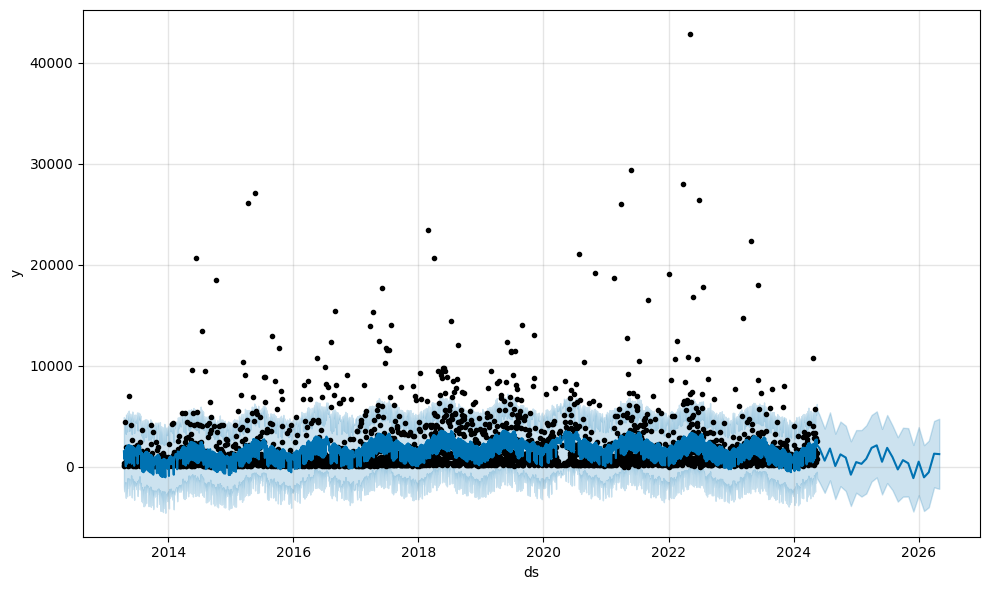

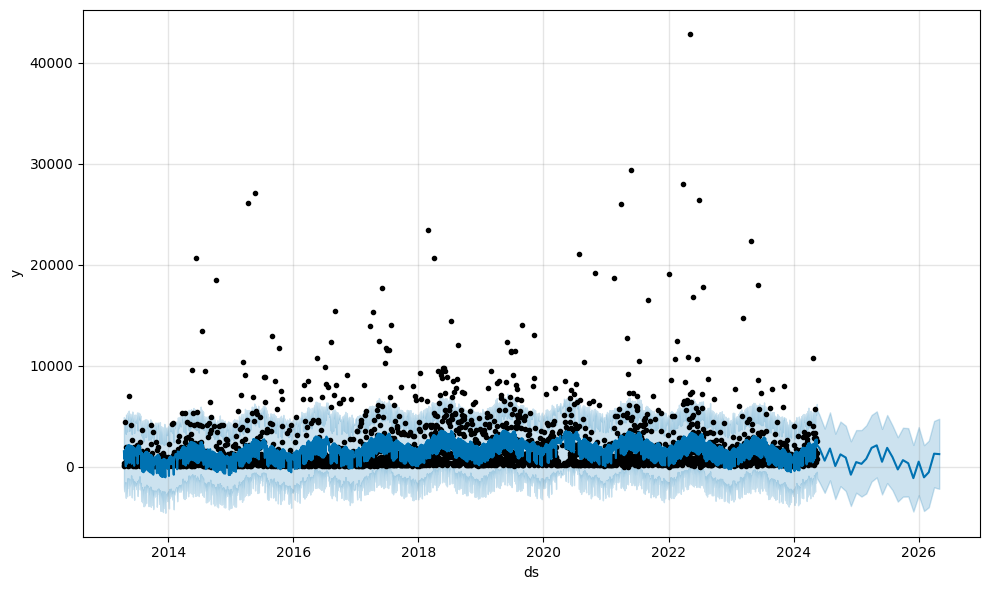

In [46]:
from prophet import Prophet
company_as_whole_amount = df.groupby(['Order Date'])['Total Selling Price'].sum().to_frame().reset_index()
company_as_whole_amount_temp = company_as_whole_amount.rename(columns={'Order Date' : 'ds', 'Total Selling Price': 'y'})
model = Prophet()
model.fit(company_as_whole_amount_temp)
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)
model.plot(forecast)

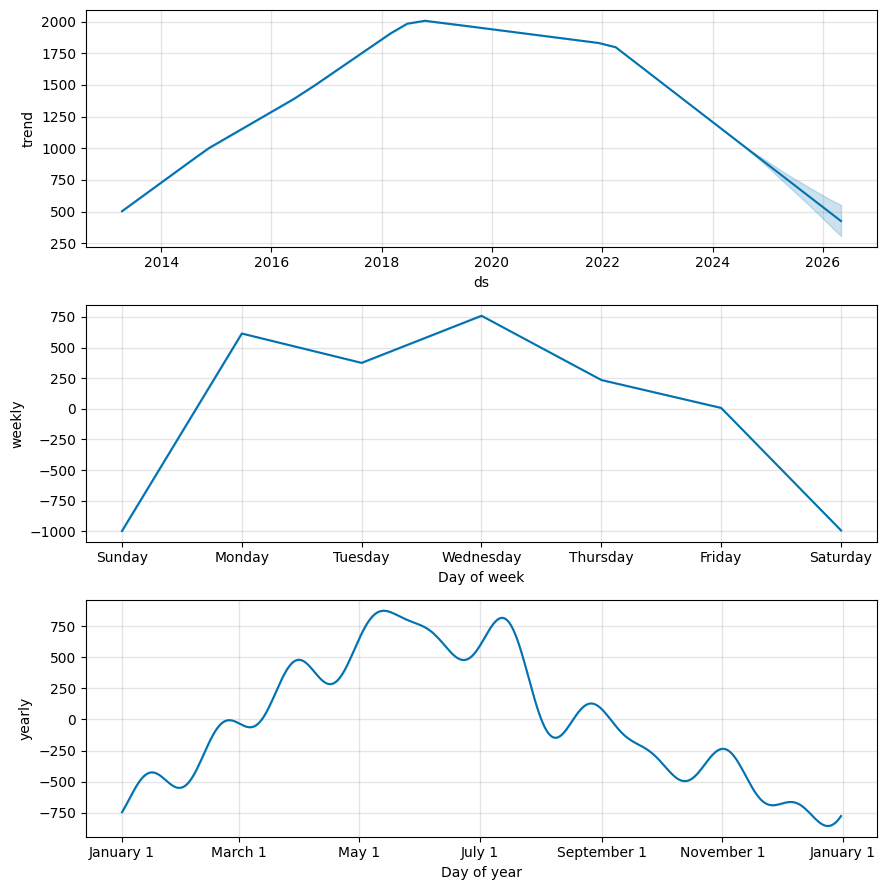

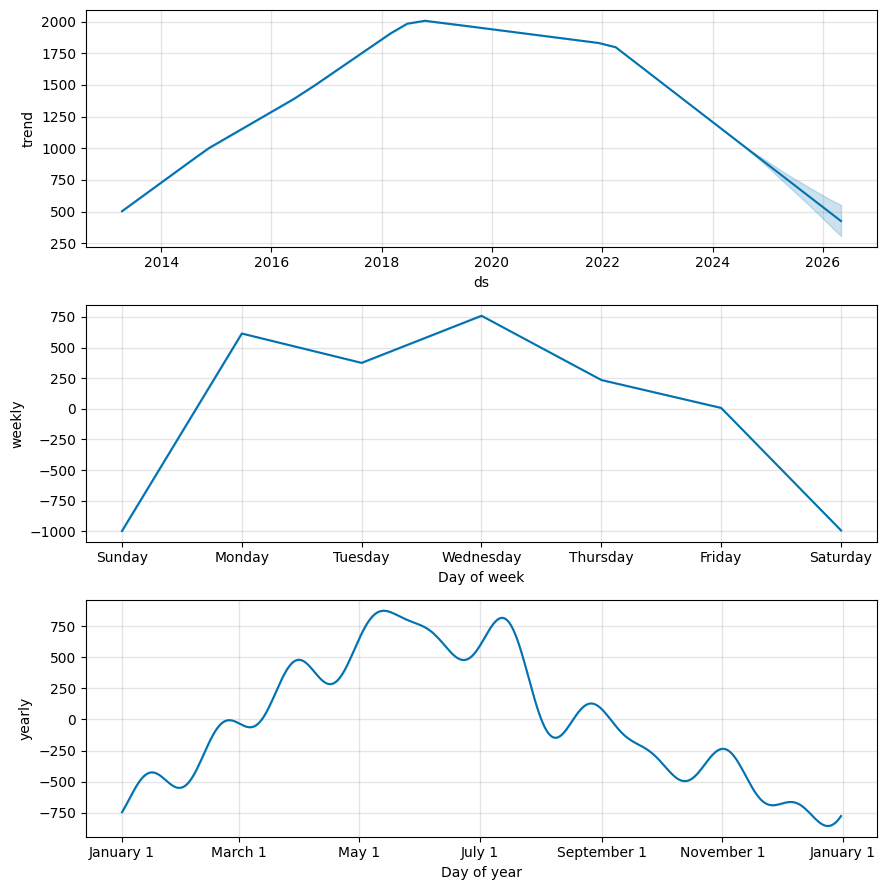

In [47]:
model.plot_components(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiff6tolh/ysn8ko5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiff6tolh/ovu91hnf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34267', 'data', 'file=/tmp/tmpiff6tolh/ysn8ko5q.json', 'init=/tmp/tmpiff6tolh/ovu91hnf.json', 'output', 'file=/tmp/tmpiff6tolh/prophet_modelvrmg4x6r/prophet_model-20240519194507.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


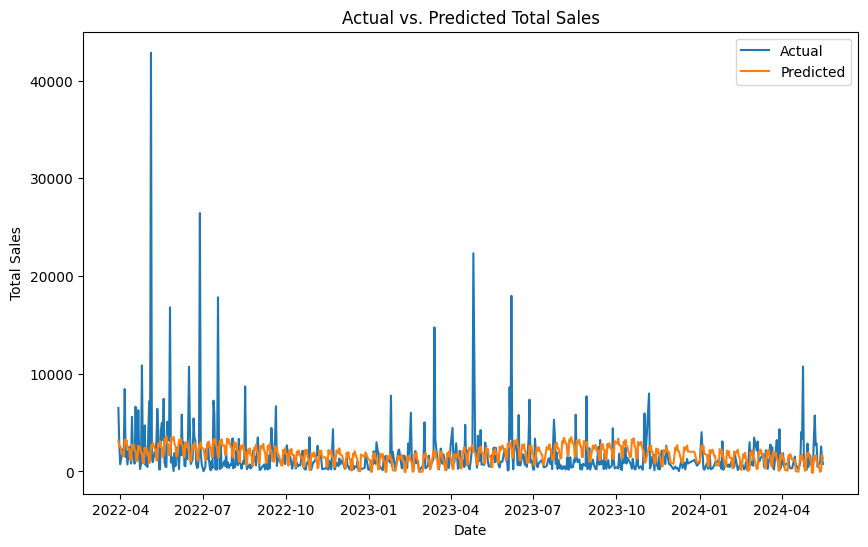

In [48]:
train_size = int(len(company_as_whole_amount_temp) * 0.8)
train_company_as_whole_df = company_as_whole_amount_temp[:train_size]
test_company_as_whole_df = company_as_whole_amount_temp[train_size:]
model = Prophet()
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_company_as_whole_df)
future = model.make_future_dataframe(periods=len(test_company_as_whole_df))
forecast = model.predict(future)
predictions = forecast[['ds', 'yhat']].tail(len(test_company_as_whole_df))
test_company_as_whole_df = test_company_as_whole_df.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)
results = pd.concat([test_company_as_whole_df, predictions['yhat']], axis=1)
plt.figure(figsize=(10, 6))
plt.plot(results['ds'], results['y'], label='Actual')
plt.plot(results['ds'], results['yhat'], label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Actual vs. Predicted Total Sales')
plt.show()

In [49]:
mae = mean_absolute_error(results['y'], results['yhat'])
mse = mean_squared_error(results['y'], results['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((results['y'] - results['yhat']) / results['y'])) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

MAE: 1582.8279094745621
MSE: 8798648.234430037
RMSE: 2966.251546047644
MAPE: 254.73812212213892%


### Step 3: Evaluating the SARIMA Model
The function begins by ensuring that the Order Date column in the DataFrame is converted to a datetime format. This is essential for time series analysis.

The total selling price is aggregated by month to analyze the sales on a monthly basis. A new column Month is created by extracting the month from the Order Date.

The Month column is converted back to a datetime format and set as the index. This step prepares the data for the SARIMA model.

The time series data is ensured to be continuous by setting the frequency to monthly start ('MS') and filling any missing values with zero.

The data is split into training and testing sets based on the specified train_size parameter. This allows for model training and evaluation.

The SARIMA model is fitted using the training data with the specified order and seasonal_order.

The model is used to forecast sales for the test period. The forecasted values are extracted for evaluation.

Various evaluation metrics are calculated to assess the model's performance:

Mean Absolute Error (**MAE**)

Mean Squared Error (**MSE**)

Root Mean Squared Error (**RMSE**)

Mean Absolute Percentage Error (**MAPE**)


In [50]:
def evaluate_sarima_model(df, order, seasonal_order, train_size=0.8):
    # Ensure 'Order Date' is in datetime format
    df['Order Date'] = pd.to_datetime(df['Order Date'])

    # Aggregate total selling price by month
    df['Month'] = df['Order Date'].dt.to_period('M')
    company_as_whole_amount = df.groupby('Month')['Total Selling Price'].sum().to_frame().reset_index()

    # Convert 'Month' back to datetime for SARIMA
    company_as_whole_amount['Month'] = company_as_whole_amount['Month'].dt.to_timestamp()
    company_as_whole_amount.set_index('Month', inplace=True)

    # Ensure continuity of the time series data
    company_as_whole_amount = company_as_whole_amount.asfreq('MS').fillna(0)

    # Split the data into training and testing sets
    train_size = int(len(company_as_whole_amount) * train_size)
    train, test = company_as_whole_amount.iloc[:train_size], company_as_whole_amount.iloc[train_size:]

    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast sales for the test period
    forecast = model_fit.get_forecast(steps=len(test))
    forecasted_values = forecast.predicted_mean

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecasted_values)
    mse = mean_squared_error(test, forecasted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Total Selling Price'] - forecasted_values) / test['Total Selling Price'])) * 100

    evaluation_metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

    # Combine train and test for full range plotting
    all_data = pd.concat([train, test])

    # Plot the historical sales, forecasted sales, and actual sales
    plt.figure(figsize=(12, 6))
    plt.plot(all_data, label='Historical Sales')
    plt.plot(test.index, forecasted_values, label='Forecasted Sales', linestyle='--')
    plt.axvline(x=test.index[0], color='gray', linestyle='--')  # Mark the train-test split
    plt.xlabel('Date')
    plt.ylabel('Total Selling Price')
    plt.title('Sales Forecasting')
    plt.legend()
    plt.show()

    return evaluation_metrics

In [51]:
def evaluate_sarima_model(df, order, seasonal_order, train_size=0.8):
    # Split the data into training and testing sets
    train_size = int(len(df) * train_size)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast sales for the test period
    forecast = model_fit.get_forecast(steps=len(test))
    forecasted_values = forecast.predicted_mean

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecasted_values)
    mse = mean_squared_error(test, forecasted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Total Selling Price'] - forecasted_values) / test['Total Selling Price'])) * 100

    evaluation_metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

    # Combine train and test for full range plotting
    all_data = pd.concat([train, test])

    # Plot the historical sales, forecasted sales, and actual sales
    plt.figure(figsize=(12, 6))
    plt.plot(all_data, label='Historical Sales')
    plt.plot(test.index, forecasted_values, label='Forecasted Sales', linestyle='--')
    plt.axvline(x=test.index[0], color='gray', linestyle='--')  # Mark the train-test split
    plt.xlabel('Date')
    plt.ylabel('Total Selling Price')
    plt.title('Sales Forecasting')
    plt.legend()
    plt.show()

    return evaluation_metrics

### Step 4: Predicting Future Sales with the SARIMA Model
The SARIMA model is initialized with the given order and seasonal order parameters. It is then fitted using the historical sales data.

The model is used to forecast sales for a specified length of time (len). The forecasted values represent the predicted sales for the future period.

A plot is generated to visualize both the historical sales and the forecasted sales. This helps in comparing the actual sales data with the model's predictions and understanding the projected trends.

The function returns the forecasted values, which can be used for further analysis or reporting.

In [52]:
def predict_sarima_model(df, order, seasonal_order, len):
    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast sales for the test period
    forecast = model_fit.get_forecast(len)
    forecasted_values = forecast.predicted_mean

    # Plot the historical sales, forecasted sales, and actual sales
    plt.figure(figsize=(12, 6))
    plt.plot(df, label='Historical Sales')
    plt.plot(forecasted_values, label='Forecasted Sales', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Total Selling Price')
    plt.title('Sales Forecasting')
    plt.legend()
    plt.show()

    return

The SARIMA model is initialized with the specified order and seasonal_order parameters. The model is then fitted using the historical sales data (df).The model forecasts sales for a specified length of time (len). The predicted mean values represent the forecasted sales for the future period.

In [53]:
def predict_sarima_model_values(df, order, seasonal_order, len):
    model = SARIMAX(df, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast sales for the test period
    forecast = model_fit.get_forecast(len)
    forecasted_values = forecast.predicted_mean


    return forecasted_values

The function evaluate_sarima_model_values assesses the performance of the SARIMA model by splitting the data into training and testing sets, fitting the model on the training data, and forecasting sales for the test period. The accuracy of the model's predictions is evaluated using key metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). These metrics provide a quantitative measure of how well the model forecasts future sales, highlighting its reliability and precision in predicting total selling prices.

In [54]:
def evaluate_sarima_model_values(df, order, seasonal_order, train_size=0.8):
    # Split the data into training and testing sets
    train_size = int(len(df) * train_size)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast sales for the test period
    forecast = model_fit.get_forecast(steps=len(test))
    forecasted_values = forecast.predicted_mean

    # Calculate evaluation metrics
    mae = mean_absolute_error(test, forecasted_values)
    mse = mean_squared_error(test, forecasted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test['Total Selling Price'] - forecasted_values) / test['Total Selling Price'])) * 100

    return mae, mse, rmse, mape

### Step 5 - test and evulate model

This part evaluates the performance of a SARIMA model to predict the company's total selling price. It begins by grouping the dataset by month, summing the total selling prices, and formatting the 'Month' column for time series analysis. The SARIMA model is then configured with specified parameters and evaluated using various accuracy metrics, providing a detailed assessment of the model's forecasting capabilities:

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observation

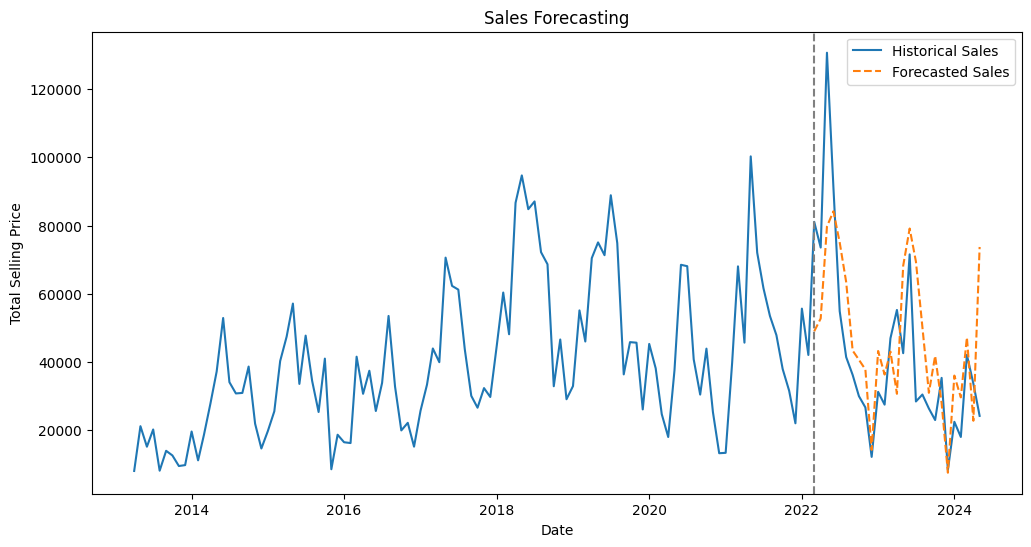

{'MAE': 16647.018903303684, 'MSE': 454208277.52157944, 'RMSE': 21312.162666458313, 'MAPE': 45.381207025246546}


In [55]:
company_as_whole_amount = df.groupby('Month')['Total Selling Price'].sum().to_frame().reset_index()
company_as_whole_amount['Month'] = company_as_whole_amount['Month'].dt.to_timestamp()
company_as_whole_amount.set_index('Month', inplace=True)
order = (3, 1, 3)
seasonal_order = (3, 2, 3, 12)
metrics = evaluate_sarima_model(company_as_whole_amount, order, seasonal_order, train_size=0.8)
print(metrics)

use the SARIMA model to forecast the company's total selling price for the next 24 months.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optim

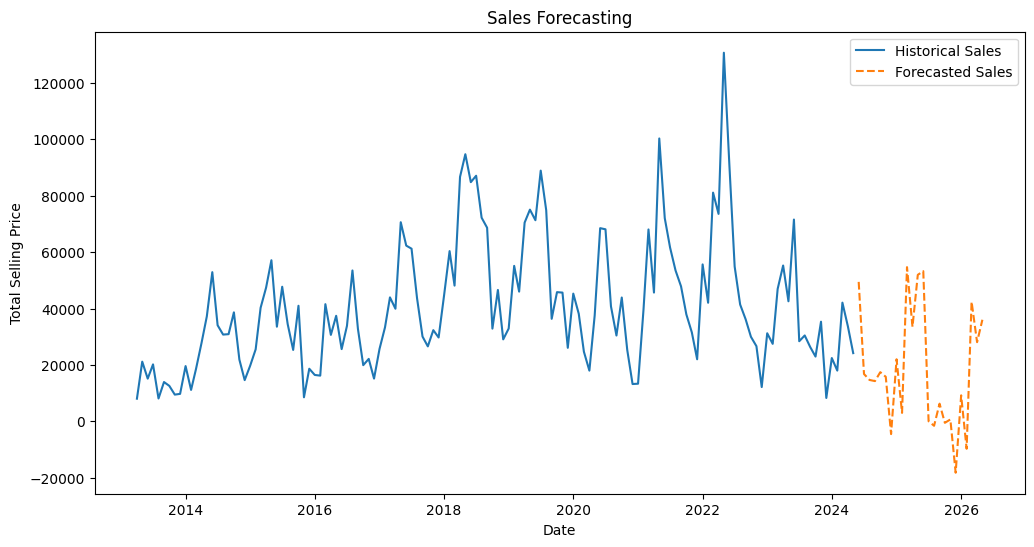

In [56]:
order = (3, 1, 3)
seasonal_order = (3, 2, 3, 12)
predict_sarima_model(company_as_whole_amount, order, seasonal_order, len=24)

Evaluate the performance of a SARIMA model for predicting the total selling price of a specific product, identified by Product ID 'Prod_5030'. The data for this product is first extracted and processed by grouping the sales data by month and summing the total selling prices. The Month column is converted to a timestamp format and set as the DataFrame index. The SARIMA model is then configured with specified order and seasonal_order parameters and evaluated using the evaluate_sarima_model function. This function splits the data into training and testing sets, fits the SARIMA model, forecasts sales for the test period, and calculates evaluation metrics (MAE, MSE, RMSE, MAPE). The metrics are printed, providing insights into the model's accuracy in predicting future sales for the product.

 Forecast the future sales of a specific product identified by Product ID 'Prod_5030' using the SARIMA model. Initially, the data for the product is extracted and processed to group the total selling price by month, converting the Month column to a timestamp format and setting it as the DataFrame index. The SARIMA model is configured with the specified order and seasonal_order parameters. The predict_sarima_model_values function is used to forecast sales for the next 24 months. Subsequently, the evaluate_sarima_model_values function is called to evaluate the model's performance by splitting the data into training and testing sets, fitting the SARIMA model, and calculating evaluation metrics (MAE, MSE, RMSE, MAPE). This provides a comprehensive analysis of the model's accuracy and forecasting capabilities for the product.

Aggregate sales data by product ID and evaluates the SARIMA model's performance for each product. For each unique product ID, process the sales data by month and configures the SARIMA model with specified parameters. Then forecast sales for the next 24 months using predict_sarima_model_values and evaluate the model's accuracy with evaluate_sarima_model_values, calculating metrics like MAE, MSE, RMSE, and MAPE. Results, including total forecasted sales and evaluation metrics, are stored in a DataFrame. Errors during processing are handled gracefully, ensuring robust evaluation across all products.

In [57]:
#Prediction by Product ID
pid = df['Product ID'].unique()
product_result = []
for id in pid:
  product = df[df['Product ID'] == id][['Order Date','Total Selling Price']]
  product['Month'] = product['Order Date'].dt.to_period('M')
  product = product.groupby('Month')['Total Selling Price'].sum().to_frame().reset_index()
  product['Month'] = product['Month'].dt.to_timestamp()
  product.set_index('Month', inplace=True)
  order = (1, 1, 1)
  seasonal_order = (1, 1, 1, 12)
  try:
    result = predict_sarima_model_values(product, order, seasonal_order, len=24)
    mae, mse, rmse, mape = evaluate_sarima_model_values(product, order, seasonal_order, train_size=0.8)
    product_result.append({
      'Product ID': id,
      'Total Selling Price': result.sum(),
      'MAE': mae,
      'MSE': mse,
      'RMSE': rmse,
      'MAPE': mape
})
  except Exception as e:
    print(f"Error processing Product ID {id}: {e}")
    product_result.append({
      'Product ID': id,
      'Total Selling Price': np.nan,
      'MAE': np.nan,
      'MSE': np.nan,
      'RMSE': np.nan,
      'MAPE': np.nan
})
result_df = pd.DataFrame(product_result)
result_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

Error processing Product ID Prod_1370: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

Error processing Product ID Prod_9450: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Error processing Product ID Prod_50062: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-54-cd4cf6d00adc>:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test['Total Selling Price'] - forecasted_values) / test['Total Selling Price'])) * 100
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self.

Error processing Product ID Prod_1300: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/

Error processing Product ID Prod_2070: LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Error processing Product ID Prod_1018: LU decomposition error.
Error processing Product ID Prod_5802: too many indices for array: array is 0-dimensional, but 1 were indexed
Error processing Product ID Prod_1150: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Error processing Product ID Prod_6340: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Error processing Product ID Prod_53101: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Error processing Product ID Prod_4403: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dis

Error processing Product ID Prod_7800: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

Error processing Product ID Prod_6601: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dis

Error processing Product ID Prod_1171: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

Error processing Product ID Prod_7903: LU decomposition error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Error processing Product ID Prod_6053: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dis

Error processing Product ID Prod_7940: too many indices for array: array is 0-dimensional, but 1 were indexed


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dis

Error processing Product ID Prod_5040: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retu

Error processing Product ID Prod_3517: Schur decomposition solver error.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will

Error processing Product ID Prod_3516: Schur decomposition solver error.


,Product ID,Total Selling Price,MAE,MSE,RMSE,MAPE
0,Prod_5030,259.017040,32.747551,1.654724e+03,40.678293,NaN
1,Prod_70018,90.609853,75.960219,2.010544e+04,141.793650,NaN
2,Prod_1000,26358.155327,1646.194025,4.269555e+06,2066.290098,70.391886
3,Prod_5080,1748.358703,234.380905,7.049277e+04,265.504747,808.826160
4,Prod_5002,10509.097585,285.012248,1.187319e+05,344.574975,157.712262
...,...,...,...,...,...,...
267,Prod_74003,1432.000117,23.333333,1.233333e+03,35.118846,NaN
268,Prod_1028,2900.000600,50.000000,2.500000e+03,50.000000,NaN
269,Prod_3013,5400.000396,88.000000,7.744000e+03,88.000000,NaN
270,Prod_3517,NaN,NaN,NaN,NaN,NaN


In [58]:
product_df = pd.DataFrame(product_result)
product_df

,Product ID,Total Selling Price,MAE,MSE,RMSE,MAPE
0,Prod_5030,259.017040,32.747551,1.654724e+03,40.678293,NaN
1,Prod_70018,90.609853,75.960219,2.010544e+04,141.793650,NaN
2,Prod_1000,26358.155327,1646.194025,4.269555e+06,2066.290098,70.391886
3,Prod_5080,1748.358703,234.380905,7.049277e+04,265.504747,808.826160
4,Prod_5002,10509.097585,285.012248,1.187319e+05,344.574975,157.712262
...,...,...,...,...,...,...
267,Prod_74003,1432.000117,23.333333,1.233333e+03,35.118846,NaN
268,Prod_1028,2900.000600,50.000000,2.500000e+03,50.000000,NaN
269,Prod_3013,5400.000396,88.000000,7.744000e+03,88.000000,NaN
270,Prod_3517,NaN,NaN,NaN,NaN,NaN


Aggregates sales data by country and forecasts future sales using the SARIMA model. For each unique shipping country, process the sales data by month, fit the SARIMA model with specified parameters, and forecast sales for the next 24 months using predict_sarima_model_values. The results, including the total forecasted sales, are stored in a DataFrame. If any errors occur during processing, they are handled gracefully by appending NaN values to the results. The final DataFrame provides a summary of the forecasted sales for each country.

In [59]:
#Prediction by Shipping Country
unique_country = df['Shipping Country'].unique()
country_result = []
for c in unique_country:
  country = df[df['Shipping Country'] == c][['Order Date','Total Selling Price']]
  country['Month'] = country['Order Date'].dt.to_period('M')
  country = country.groupby('Month')['Total Selling Price'].sum().to_frame().reset_index()
  country['Month'] = country['Month'].dt.to_timestamp()
  country.set_index('Month', inplace=True)
  order = (1, 1, 1)
  seasonal_order = (1, 1, 1, 12)
  try:
    result = predict_sarima_model_values(country, order, seasonal_order, len=24)
    country_result.append({
      'Country': c,
      'Total Selling Price': result.sum(),
})
  except Exception as e:
    print(f"Error processing Shipping Country {c}: {e}")
    country_result.append({
      'Country': c,
      'Total Selling Price': np.nan,
})
result_df = pd.DataFrame(country_result)
result_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning

Error processing Shipping Country Brunei Darussalam: Shape of passed values is (4, 27), indices imply (48, 27)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dis

,Country,Total Selling Price
0,United States,337913.036824
1,Germany,19590.452212
2,Hong Kong,7947.000175
3,Brunei Darussalam,NaN
4,Japan,143138.198939
5,"Tanzania, United Republic Of",17636.702320
6,Virgin Islands (US),26206.201517
7,Bahamas,10208.301153
8,Gibraltar,36113.454077
9,Russian Federation,6539.303966
